## **Overview**:

| <br/><font size="3"><b> Focus </b></font><br/><br/>  | <br/><font size="3"><b> Description </b></font><br/><br/> |
| :-- | :-- |
| <br/><font size="3"> <b>Title</b> </font>  <br/><br/>| <br/><font size="3"> Semantic Segmentation of Images Using U-Net</font> <br/><br/>|
| <br/><font size="3"> <b>Category</b> </font> <br/><br/>| <br/><font size="3">Computer Vision – Semantic Image Segmentation </font> <br/><br/>|
| <br/><font size="3"><b>Goals</b> </font>  <br/><br/>| <br/><font size="3">1. Develop a model to perform semantic segmentation on images from the CARLA simulator.<br/>  2. Assess model performance using multiple evaluation metrics. <br/>3. Generate segmentation masks from the model and compare them to the ground-truth annotations. </font> <br/><br/>|
| <br/><font size="3"> <b>Dataset Overview </b> </font> <br/><br/>| <br/><font size="3"> The dataset includes 5,000 RGB images and their corresponding semantic segmentation labels, generated using the CARLA self-driving simulator. It was initially created for the 2018 Lyft–Udacity Perception Challenge. </font> <br/><br/>|
| <br/><font size="3"> <b> Evaluation Metrics</b> </font> <br/><br/>| <br/><font size="3"> Model Accuracy, Mean Precision, Mean Recall, Mean Specificity, Mean IoU, Mean TDR, and Dice Coefficient (F1 Score). </font> <br/><br/>|
| <font size="3"> <b>Model Used </b> </font> | <br/><font size="3"> <a href="https://arxiv.org/pdf/1505.04597.pdf"> <b> U-Net architecture designed for pixel-level classification.</b></a> </font> <br/><br/>|
| <br/><font size="3"> <b>Core Libraries</b> </font> <br/><br/>| <br/><font size="3"> <a href="https://keras.io"><b>Keras</b></a>, <a href="https://imageio.readthedocs.io/"><b>ImageIO</b></a>, <a href="https://scikit-learn.org"><b> Scikit-Learn </b></a>, <a href="https://numpy.org"><b>Numpy</b></a>, <a href="https://matplpotlib.org"><b>Matplotlib</b></a></font> <br/><br/>|

<br/>

<a class="anchor" id="1" name='1'></a>
## **Import Required Packages**

In [1]:
import numpy as np
import pandas as pd
import imageio
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="2" name="2"></a>
## **Data Preparation**

For this semantic segmentation task, we utilize the Lyft Udacity Self-Driving Car Dataset. Although the original dataset is split across five directories (dataA to dataE), we use only dataA for faster experimentation and reduced training time.

Images and their corresponding segmentation masks from dataA are loaded, preprocessed, and formatted into a dataset suitable for training the U-Net model.

<a class="anchor" id="2-1" name="2-1"></a>
# Load the images and masks from their directories

In [2]:
# Mount Google Drive to access files stored in your Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset folder paths
image_path = ["/content/drive/MyDrive/CameraRGB/"]  # Path to input images
mask_path = ["/content/drive/MyDrive/CameraSeg/"]   # Path to segmentation masks


Mounted at /content/drive


# Image Path Loader

In [3]:
import os

def list_image_paths(directory_paths):
    # Initialize an empty list to hold full file paths
    image_paths = []

    # Loop through each directory in the list
    for directory in range(len(directory_paths)):
        image_filenames = os.listdir(directory_paths[directory])  # Get all file names in the directory
        for image_filename in image_filenames:
            image_paths.append(directory_paths[directory] + image_filename)  # Append full path to the list

    return image_paths


# Dataset Overview

In [4]:
# Load all image and mask paths from the specified directories
image_paths = list_image_paths(image_path)
mask_paths = list_image_paths(mask_path)

# Count the number of image-mask pairs
number_of_images, number_of_masks = len(image_paths), len(mask_paths)

# Print summary statistics and one example from each
print(f"1. There are {number_of_images} images and {number_of_masks} masks in our dataset")
print(f"2. An example of an image path is: \n {image_paths[0]}")
print(f"3. An example of a mask path is: \n {mask_paths[0]}")


1. There are 1000 images and 1000 masks in our dataset
2. An example of an image path is: 
 /content/drive/MyDrive/CameraRGB/02_00_080.png
3. An example of a mask path is: 
 /content/drive/MyDrive/CameraSeg/02_00_020.png


# Visualizing Random Samples from the Dataset

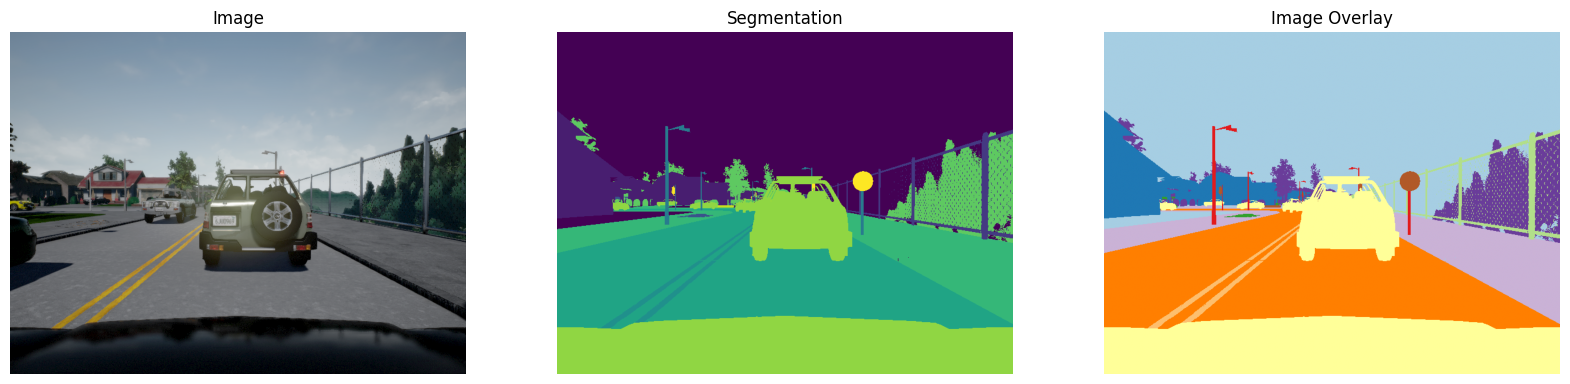

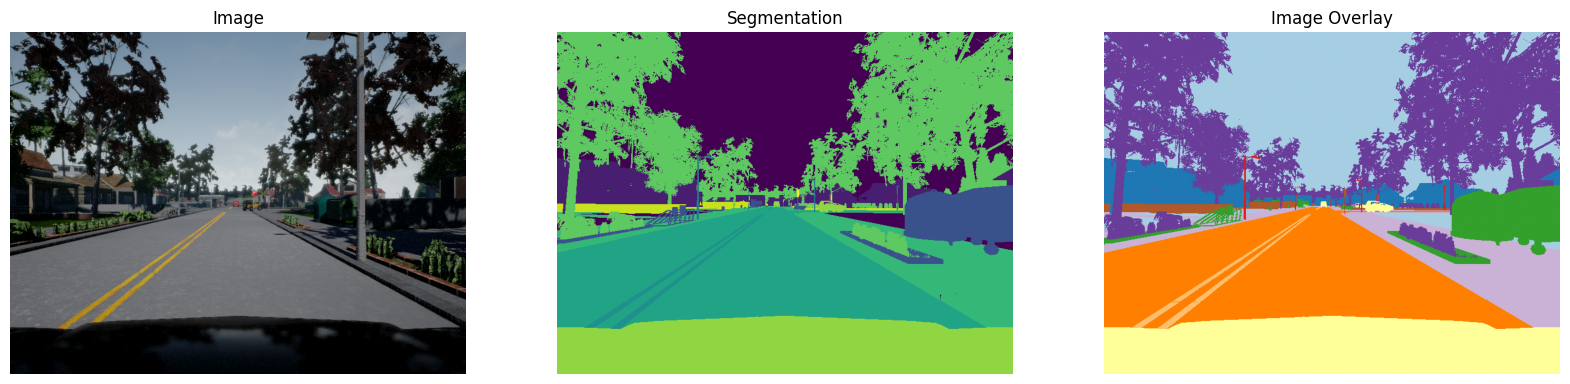

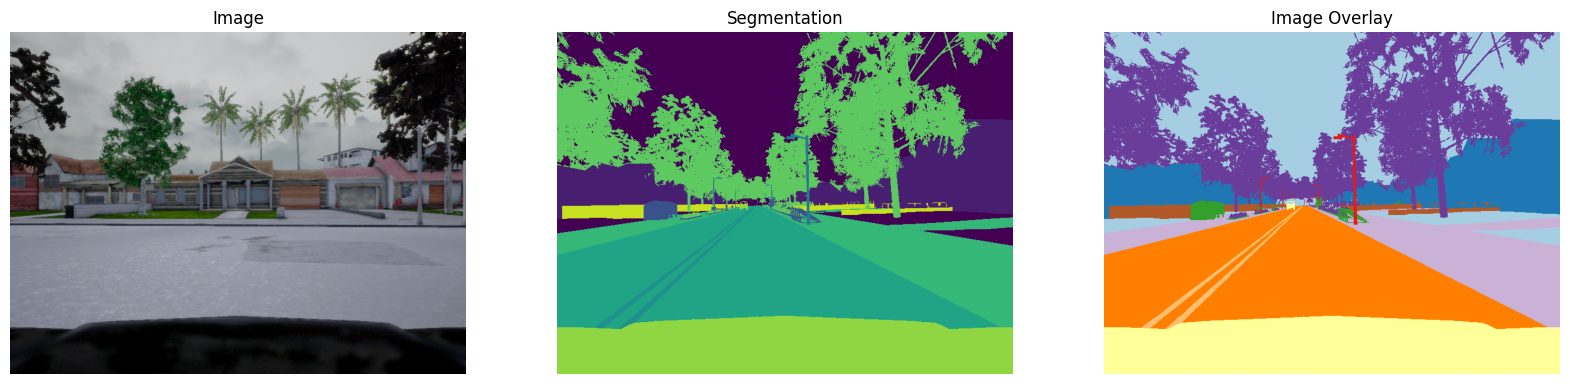

In [5]:
# Get total number of samples in the dataset
number_of_samples = len(image_paths)

# Randomly select and visualize 3 image-mask pairs
for i in range(3):
    # Randomly choose an index
    N = random.randint(0, number_of_samples - 1)

    # Read the image and corresponding mask
    img = imageio.imread(image_paths[N])
    mask = imageio.imread(mask_paths[N])

    # Flatten the multi-channel mask by taking the max value across channels
    # This is typically needed if the mask is one-hot encoded
    mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])])\
            .reshape(img.shape[0], img.shape[1])

    # Plot image, mask, and overlay side by side
    fig, arr = plt.subplots(1, 3, figsize=(20, 8))

    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")

    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")

    arr[2].imshow(mask, cmap='Paired')
    arr[2].set_title('Image Overlay')
    arr[2].axis("off")


# Split the image and mask paths into training, validation, and test sets

In [6]:
# Get the list of image and mask filenames
image_filenames = os.listdir(image_path[0])  # Access the first element of image_path list
mask_filenames = os.listdir(mask_path[0])  # Access the first element of mask_path list

# Find common filenames
common_filenames = list(set(image_filenames) & set(mask_filenames))

# Filter image and mask paths based on common filenames
image_paths = [os.path.join(image_path[0], filename) for filename in common_filenames]
mask_paths = [os.path.join(mask_path[0], filename) for filename in common_filenames]

# Now you can proceed with train_test_split
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, train_size=0.8, random_state=0)
validation_image_paths, test_image_paths, validation_mask_paths, test_mask_paths = train_test_split(val_image_paths, val_mask_paths, train_size=0.80, random_state=0)

print(f'There are {len(train_image_paths)} images in the Training Set')
print(f'There are {len(validation_image_paths)} images in the Validation Set')
print(f'There are {len(test_image_paths)} images in the Test Set')

There are 800 images in the Training Set
There are 160 images in the Validation Set
There are 40 images in the Test Set


<a class="anchor" id="2-2" name="2-2"></a>
# Data Pipeline with `tf.data.Dataset`

We use the `tf.data.Dataset` API to efficiently load and preprocess images and masks. It builds an optimized, asynchronous pipeline that reads from disk, applies transformations, batches data, and feeds it to the GPU — minimizing performance bottlenecks.


# Image & Mask Reader with Preprocessing

In [7]:
def read_image(image_path, mask_path):
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0,1]
    image = tf.image.resize(image, (256, 256), method='nearest')

    # Read and decode the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)  # Flatten channel-wise
    mask = tf.image.resize(mask, (256, 256), method='nearest')

    return image, mask


# Data Generator Pipeline

In [8]:
def data_generator(image_paths, mask_paths, buffer_size, batch_size):
    # Convert image and mask path lists to TensorFlow constants
    image_list = tf.constant(image_paths)
    mask_list = tf.constant(mask_paths)

    # Create a dataset from the file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))

    # Map the read_image function to load and preprocess each pair
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Cache, shuffle, and batch the dataset
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)

    return dataset


# Dataset Initialization – Train, Validation, and Test Splits

In [9]:
# Set batch and buffer sizes
batch_size = 32
buffer_size = 500

# Generate dataset pipelines for each data split
train_dataset = data_generator(train_image_paths, train_mask_paths, buffer_size, batch_size)
validation_dataset = data_generator(validation_image_paths, validation_mask_paths, buffer_size, batch_size)
test_dataset = data_generator(test_image_paths, test_mask_paths, buffer_size, batch_size)


# Model Architecture and Training

We use the **U-Net** architecture for semantic segmentation. Originally designed for biomedical image tasks, U-Net has since become a widely adopted model for pixel-wise classification problems.

## Contracting Path (Encoder)
The encoder acts like a typical CNN, using repeated 3×3 convolutions with ReLU activation, followed by 2×2 max-pooling. Each downsampling step doubles the number of feature channels while reducing spatial dimensions. Intermediate feature maps are saved for use in the decoder.

## Expanding Path (Decoder)
The decoder upsamples the feature maps using transposed convolutions. Each upsampling step is followed by a skip connection (concatenation with the matching encoder feature map) and two 3×3 convolutions with ReLU. This restores spatial resolution while reducing channel depth.

## Final Output Layer
A 1×1 convolution maps each pixel's final feature vector to the number of output classes, producing a segmentation map.

U-Net’s structure helps preserve both **context** and **location**, making it ideal for tasks where spatial accuracy matters.

<center><img src="https://i.ibb.co/0287bZ1/U-Net.webp" alt="U-Net" border="0"></center>


#  Encoding Block (Downsampling Layer)

In [10]:
def encoding_block(inputs, filters, dropout_probability=0, max_pooling=True):
    # First convolution layer
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Second convolution layer
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Save output for skip connection
    skip_connection = x

    # Apply max pooling if specified
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(skip_connection)
    else:
        next_layer = skip_connection

    return next_layer, skip_connection


# Decoding Block (Upsampling Layer)

In [11]:
def decoding_block(inputs, skip_connection_input, filters):
    # Upsample the input using transposed convolution
    x = tf.keras.layers.Conv2DTranspose(
        filters, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'
    )(inputs)

    # Align shapes before concatenation (in case of mismatch due to padding)
    x = tf.keras.layers.Cropping2D((
        (x.shape[1] - skip_connection_input.shape[1]) // 2,
        (x.shape[2] - skip_connection_input.shape[2]) // 2
    ))(x)

    # Concatenate the upsampled tensor with the skip connection
    x = tf.keras.layers.concatenate([x, skip_connection_input], axis=3)

    # Apply two convolutional layers with batch norm and ReLU
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    return x


# Build U-Net Model

In [12]:
def unet_model(input_size, filters, n_classes):
    inputs = Input(input_size)

    # Encoder (contracting path)
    C1, skip1 = encoding_block(inputs, filters, max_pooling=True)
    C2, skip2 = encoding_block(C1, filters * 2, max_pooling=True)
    C3, skip3 = encoding_block(C2, filters * 4, max_pooling=True)
    C4, skip4 = encoding_block(C3, filters * 8, max_pooling=False)  # No pooling at the bottleneck

    # Decoder (expanding path)
    D1 = decoding_block(C4, skip4, filters * 8)
    D2 = decoding_block(D1, skip3, filters * 4)
    D3 = decoding_block(D2, skip2, filters * 2)
    D4 = decoding_block(D3, skip1, filters)

    # Final 1×1 convolution to produce the output segmentation map
    C11 = Conv2D(filters=n_classes, kernel_size=(1, 1), activation='sigmoid', padding='same')(D4)

    # Create the model
    model = Model(inputs=inputs, outputs=C11)

    return model


# Initialize and Summarize the U-Net Model

In [13]:
# Define input shape and model configuration
img_height = 256
img_width = 256
num_channels = 3
filters = 32
n_classes = 13

# Build the U-Net model
model = unet_model((img_height, img_width, num_channels), filters=filters, n_classes=n_classes)

# Print the model architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 4,508,781 (17.20 MB)

 Trainable params: 4,504,941 (17.18 MB)

 Non-trainable params: 3,840 (15.00 KB)

<a class="anchor" id="3-2" name="3-2"></a>
### **Model Training**

In [14]:
# Compile the model with Adam optimizer and sparse categorical crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Stop training early if validation accuracy stops improving
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=1e-1, patience=5, verbose=1, min_lr=2e-6)

# Define batch size and number of training epochs
batch_size = 32
epochs = 30


In [15]:
# Train the model with training and validation data
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=1,
    callbacks=[callback, reduce_lr],
    batch_size=batch_size,
    shuffle=True
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 764s 13s/step - accuracy: 0.5276 - loss: 1.7030 - val_accuracy: 0.4451 - val_loss: 21.9896 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 67s 698ms/step - accuracy: 0.7857 - loss: 0.8192 - val_accuracy: 0.3724 - val_loss: 6.3129 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 686ms/step - accuracy: 0.8710 - loss: 0.5695 - val_accuracy: 0.4791 - val_loss: 1.9939 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 668ms/step - accuracy: 0.9036 - loss: 0.4178 - val_accuracy: 0.4405 - val_loss: 2.5996 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 666ms/step - accuracy: 0.9164 - loss: 0.3481 - val_accuracy: 0.5474 - val_loss: 1.7710 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 671ms/step - accuracy: 0.9231 - loss: 0.3054 - val_accuracy: 0.5026 - val_loss: 1.8601 - learning_rate: 0.0010
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 675ms/step - accuracy: 0.9300 - loss: 0.

# Training History Visualization

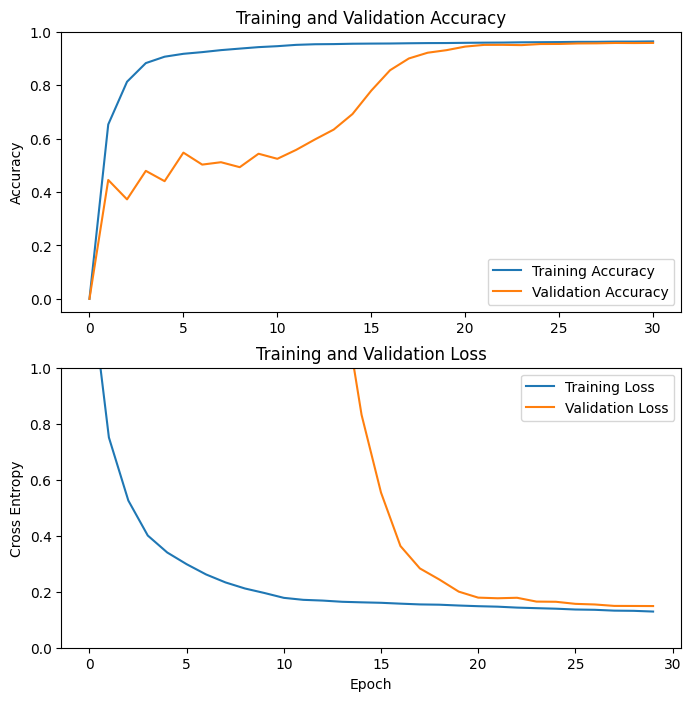

In [16]:
# Extract accuracy and loss values from training history
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Set up the plot layout
plt.figure(figsize=(8, 8))

# Plot accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

# Display the plots
plt.show()


In [17]:
model.save('carla-image-segmentation-model.h5')

<a class="anchor" id="3-3" name="3-3"></a>
### **Compute Model Accuracy**

In [18]:
# Evaluate model on training data
train_loss, train_accuracy = model.evaluate(train_dataset, batch_size=32)

# Evaluate model on validation data
validation_loss, validation_accuracy = model.evaluate(validation_dataset, batch_size=32)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_dataset, batch_size=32)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.9637 - loss: 0.1289
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.9578 - loss: 0.1495
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.9626 - loss: 0.1345


In [19]:
print(f'Model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Validation Dataset: {round(validation_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')

Model Accuracy on the Training Dataset: 96.27%
Model Accuracy on the Validation Dataset: 95.81%
Model Accuracy on the Test Dataset: 96.31%


<a class="anchor" id="4" name="4"></a>
## **Model Evaluation**


# Generate Predictions and True Masks from Dataset

In [20]:
def create_mask(dataset, model):
    true_masks, predicted_masks = [], []

    # Iterate through the dataset and generate predictions
    for images, masks in dataset:
        pred_masks = model.predict(images)  # Get raw model predictions
        pred_masks = tf.expand_dims(tf.argmax(pred_masks, axis=-1), axis=-1)  # Convert to class labels

        true_masks.extend(masks)
        predicted_masks.extend(pred_masks)

    # Convert to NumPy arrays
    true_masks = np.array(true_masks)
    predicted_masks = np.array(predicted_masks)

    return true_masks, predicted_masks


# Generate True vs Predicted Masks

In [21]:
# Generate predictions and true masks for training set
true_train_masks, predicted_train_masks = create_mask(train_dataset, model)

# Generate predictions and true masks for validation set
true_validation_masks, predicted_validation_masks = create_mask(validation_dataset, model)

# Generate predictions and true masks for test set
true_test_masks, predicted_test_masks = create_mask(test_dataset, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

<a class="anchor" id="4-2" name="4-2"></a>
### **Evaluate Predicted Segmentations**

# Evaluation Metrics Function

In [22]:
def evaluate_model(true_masks, predicted_masks, n_classes, smooth=1e-6):
    # Lists to collect metric results
    class_wise_true_positives, class_wise_true_negatives = [], []
    class_wise_false_positives, class_wise_false_negatives = [], []
    class_wise_precisions, class_wise_recalls = [], []
    class_wise_specificities, class_wise_ious = [], []
    class_wise_tdrs, class_wise_f1_scores = [], []
    classes = []

    # Evaluate each class
    for clas in range(n_classes):
        true_positives = true_negatives = false_positives = false_negatives = 0

        number_of_masks = true_masks.shape[0]

        for mask_id in range(number_of_masks):
            true_positive = np.sum(np.logical_and(true_masks[mask_id] == clas, predicted_masks[mask_id] == clas))
            true_negative = np.sum(np.logical_and(true_masks[mask_id] != clas, predicted_masks[mask_id] != clas))
            false_positive = np.sum(np.logical_and(true_masks[mask_id] != clas, predicted_masks[mask_id] == clas))
            false_negative = np.sum(np.logical_and(true_masks[mask_id] == clas, predicted_masks[mask_id] != clas))

            true_positives += true_positive
            true_negatives += true_negative
            false_positives += false_positive
            false_negatives += false_negative

        # Metric calculations (with smoothing to avoid division by zero)
        recall = true_positives / (true_positives + false_negatives + smooth)
        precision = true_positives / (true_positives + false_positives + smooth)
        specificity = true_negatives / (true_negatives + false_positives + smooth)
        tdr = recall  # same as recall
        iou = true_positives / (true_positives + false_positives + false_negatives + smooth)
        f1_score = 2 * (precision * recall) / (precision + recall + smooth)

        # Append metrics for current class
        class_wise_true_positives.append(true_positives)
        class_wise_true_negatives.append(true_negatives)
        class_wise_false_positives.append(false_positives)
        class_wise_false_negatives.append(false_negatives)
        class_wise_recalls.append(recall)
        class_wise_precisions.append(precision)
        class_wise_specificities.append(specificity)
        class_wise_ious.append(iou)
        class_wise_tdrs.append(tdr)
        class_wise_f1_scores.append(f1_score)
        classes.append("Class " + str(clas + 1))

    # Overall average metrics
    total_true_positives = np.sum(class_wise_true_positives)
    total_true_negatives = np.sum(class_wise_true_negatives)
    total_false_positives = np.sum(class_wise_false_positives)
    total_false_negatives = np.sum(class_wise_false_negatives)
    mean_recall = round(np.average(class_wise_recalls), 2)
    mean_precision = round(np.average(class_wise_precisions), 2)
    mean_specificity = round(np.average(class_wise_specificities), 2)
    mean_iou = round(np.average(class_wise_ious), 2)
    mean_tdr = round(np.average(class_wise_tdrs), 2)
    mean_f1_score = round(np.average(class_wise_f1_scores), 2)

    # Class-wise metrics dictionary
    class_wise_evaluations = {
        "Class": classes,
        "True Positive Pixels": class_wise_true_positives,
        "True Negative Pixels": class_wise_true_negatives,
        "False Positive Pixels": class_wise_false_positives,
        "False Negative Pixels": class_wise_false_negatives,
        "Recall": class_wise_recalls,
        "Precision": class_wise_precisions,
        "Specificity": class_wise_specificities,
        "IoU": class_wise_ious,
        "TDR": class_wise_tdrs,
        "F1-Score": class_wise_f1_scores
    }

    # Overall summary dictionary
    overall_evaluations = {
        "Class": "All Classes",
        "True Positive Pixels": total_true_positives,
        "True Negative Pixels": total_true_negatives,
        "False Positive Pixels": total_false_positives,
        "False Negative Pixels": total_false_negatives,
        "Recall": mean_recall,
        "Precision": mean_precision,
        "Specificity": mean_specificity,
        "IoU": mean_iou,
        "TDR": mean_tdr,
        "F1-Score": mean_f1_score
    }

    # Final evaluation result
    evaluations = {
        "Overall Evaluations": overall_evaluations,
        "Class-wise Evaluations": class_wise_evaluations
    }

    return evaluations


# Format Evaluation Metrics as DataFrame

In [23]:
def show_evaluations(evaluations,
                     metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1 Score"],
                     class_list=None,
                     display_evaluations="All"):

    # Extract overall and class-wise evaluation results
    overall_evaluations = evaluations["Overall Evaluations"]
    class_wise_evaluations = evaluations["Class-wise Evaluations"]

    # Validate metric names
    for metric in metrics:
        if metric not in overall_evaluations:
            raise ValueError("Invalid metric in list. Use only: "
                             "'True Positive', 'True Negative', 'False Positive', 'False Negative', "
                             "'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'")

    # Validate class names if provided
    if class_list is not None and all(isinstance(class_, str) for class_ in class_list):
        if len(class_list) == len(class_wise_evaluations["Class"]):
            class_list = [class_list]
        else:
            raise ValueError("class_list length must match the number of segmentation classes")
    else:
        class_list = [class_wise_evaluations["Class"]]

    # Prepare data arrays
    overall_data = [overall_evaluations["Class"]] + [overall_evaluations[metric] for metric in metrics]
    classwise_data = class_list + [class_wise_evaluations[metric] for metric in metrics]
    overall_data = np.array(overall_data).reshape(1, -1)
    classwise_data = np.array(classwise_data).T

    # Choose which evaluations to display
    if display_evaluations.lower() == "all":
        data = np.concatenate((overall_data, classwise_data), axis=0)
    elif display_evaluations.lower() == "overall":
        data = overall_data
    elif display_evaluations.lower() in ["class-wise", "classwise"]:
        data = classwise_data
    else:
        raise ValueError("Invalid display_evaluations value. Use 'All', 'Overall', or 'Class-wise'.")

    # Create DataFrame for the selected evaluation metrics
    dataframe = pd.DataFrame(data)
    dataframe.columns = ["Class"] + metrics

    return dataframe


# Display Train Set Evaluation Results

In [24]:
# Evaluate the model on the training set
model_evaluation_on_train_dataset = evaluate_model(true_train_masks, predicted_train_masks, n_classes=13)

# Display selected evaluation metrics in a tabular format
show_evaluations(
    model_evaluation_on_train_dataset,
    metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"],
    class_list=None,
    display_evaluations="All"
)


Class              Recall           Precision         Specificity  \
0   All Classes                0.66                0.76                 1.0   
1       Class 1  0.9799546448949522  0.9885856129509415  0.9948557119753337   
2       Class 2  0.9775639602251942  0.9076139408932177  0.9909554401793771   
3       Class 3  0.4745821378839705  0.7395456574938958  0.9983255816569694   
4       Class 4  0.5696090690850234  0.8020383246133428   0.998515526058121   
5       Class 5                 0.0                 0.0  0.9999999999999809   
6       Class 6  0.1027695313964046   0.901770699347058  0.9999428902151902   
7       Class 7  0.8416756345958778  0.9542275611808716  0.9996957529673791   
8       Class 8  0.9925992259824944  0.9866197986738924  0.9967693659183857   
9       Class 9  0.9706015286025824  0.9296708708934102  0.9936945723432266   
10     Class 10  0.9545665433789635  0.9146474609034566  0.9874873584082783   
11     Class 11  0.9905277480478237  0.9914306845227705  0.9982774049744704   
12     Class 12   0.733036514653437  0.8195953393141613   0.998855560625158   
13     Class 13                 0.0                 0.0  0.9999999999999809   

                    IoU                 TDR            F1-Score  
0                  0.62                0.66                0.68  
1    0.9689907736496298  0.9799546448949522    0.98425070790509  
2    0.8890935713848133  0.9775639602251942  0.9412906943619981  
3   0.40662003970638755  0.4745821378839705   0.578151445764908  
4    0.4993974177783371  0.5696090690850234  0.6661303371219225  
5                   0.0                 0.0                 0.0  
6   0.10163180211713733  0.1027695313964046  0.1845111964798431  
7    0.8090129176145083  0.8416756345958778  0.8944242014629463  
8    0.9794150339466136  0.9925992259824944  0.9895999800959268  
9    0.9042094837857618  0.9706015286025824  0.9496948898256058  
10   0.8764907744532403  0.9545665433789635  0.9341802448243591  
11   0.9821193226138484  0.9905277480478237  0.9909785106066985  
12   0.6311924594461388   0.733036514653437   0.773902612484061  
13                  0.0                 0.0                 0.0

#  Display Validation Set Evaluation Results

In [25]:
# Evaluate the model on the validation set
model_evaluation_on_validation_dataset = evaluate_model(true_validation_masks, predicted_validation_masks, n_classes=13)

# Display selected metrics in tabular format
show_evaluations(
    model_evaluation_on_validation_dataset,
    metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"],
    class_list=None,
    display_evaluations="All"
)


Class               Recall           Precision         Specificity  \
0   All Classes                 0.64                0.75                 1.0   
1       Class 1   0.9785280901932308  0.9885683972453542  0.9950398778184467   
2       Class 2   0.9715463421130278  0.8930121428263492  0.9887769590391902   
3       Class 3  0.44458686738807296  0.7301542274335218  0.9982580551455562   
4       Class 4   0.4886759336560011  0.7408962190209484  0.9982457250868733   
5       Class 5                  0.0                 0.0  0.9999999999999046   
6       Class 6  0.09683829768014919  0.8418090060477854  0.9999219421482134   
7       Class 7   0.8523125549513489  0.9460052056676003  0.9996332381019779   
8       Class 8    0.991008102572224  0.9857515697873399  0.9965453237168751   
9       Class 9   0.9628160783550558  0.9203469295431946  0.9931284851665861   
10     Class 10   0.9492105527425534  0.9099115416560644  0.9861798956730692   
11     Class 11   0.9865342430980212  0.9893979381086232  0.9978602429001577   
12     Class 12   0.6218709545462715  0.7625444884327945  0.9986351816947624   
13     Class 13                  0.0                 0.0  0.9999999999999045   

                    IoU                  TDR             F1-Score  
0                   0.6                 0.64                 0.67  
1    0.9675794462300563   0.9785280901932308   0.9835221202396875  
2    0.8702518980742695   0.9715463421130278   0.9306248342660572  
3    0.3818465742699056  0.44458686738807296   0.5526608472034483  
4    0.4173513639135771   0.4886759336560011   0.5889168135852881  
5                   0.0                  0.0                  0.0  
6   0.09510756342854088  0.09683829768014919  0.17369519721864682  
7     0.812773456480156   0.8523125549513489   0.8967176804209254  
8    0.9770129680977444    0.991008102572224   0.9883723471860447  
9     0.888757154395265   0.9628160783550558   0.9411021214428116  
10   0.8676676882230364   0.9492105527425534    0.929145186786642  
11   0.9762143150250946   0.9865342430980212    0.987963515445065  
12    0.520982693267718   0.6218709545462715   0.6850601512436251  
13                  0.0                  0.0                  0.0

# Display Test Set Evaluation Results

In [26]:
# Evaluate the model on the test set
model_evaluation_on_test_dataset = evaluate_model(true_test_masks, predicted_test_masks, n_classes=13)

# Display selected evaluation metrics
show_evaluations(
    model_evaluation_on_test_dataset,
    metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"],
    class_list=None,
    display_evaluations="All"
)


Class               Recall           Precision         Specificity  \
0   All Classes                 0.65                0.75                 1.0   
1       Class 1    0.980736840161442  0.9899998758044809  0.9955480484003243   
2       Class 2   0.9811251539721699   0.908171654057918   0.989125369157552   
3       Class 3   0.5114936496094785  0.7580502981198833  0.9982004420599045   
4       Class 4   0.4535235624511926  0.7072969732763488  0.9984976676738619   
5       Class 5                  0.0                 0.0  0.9999999999996186   
6       Class 6  0.11703903950727208  0.9097651415885258  0.9999440369229815   
7       Class 7   0.8942230676364525  0.9553428173625338  0.9996790268860152   
8       Class 8   0.9916875277666486   0.988502921578749  0.9972077984530848   
9       Class 9   0.9668597050059529  0.9327326180368568  0.9936998068385844   
10     Class 10    0.953313663412428  0.9153376769758299  0.9887234365698196   
11     Class 11   0.9907759101180628  0.9931186172145532   0.998670915729046   
12     Class 12   0.6411398040485945  0.7182641948027048  0.9987005188718102   
13     Class 13                  0.0                 0.0  0.9999999999996181   

                    IoU                  TDR             F1-Score  
0                  0.61                 0.65                 0.67  
1    0.9711164199893877    0.980736840161442   0.9853460885136838  
2    0.8925771095310455   0.9811251539721699   0.9432393878123263  
3    0.4397088458976837   0.5114936496094785   0.6108297532377709  
4   0.38185568676662934   0.4535235624511926   0.5526703858577027  
5                   0.0                  0.0                  0.0  
6   0.11569598364256103  0.11703903950727208  0.20739676875234694  
7    0.8583441448821131   0.8942230676364525   0.9237725780182796  
8    0.9803797125434773   0.9916875277666486     0.99009216388102  
9     0.903836471217197   0.9668597050059529   0.9494891069420988  
10   0.8760666320370629    0.953313663412428   0.9339392836614492  
11   0.9840204620284879   0.9907759101180628    0.991945380459515  
12   0.5123035872806224   0.6411398040485945   0.6775137144560419  
13                  0.0                  0.0                  0.0

## **Predict image segmentations using the trained Model**


### **Load our model**

In [27]:
model = load_model('carla-image-segmentation-model.h5')

# Create Single-Class Mask from Model Prediction

In [28]:
def create_mask(pred_mask):
    # Take the argmax across the class axis to get the predicted label per pixel
    pred_mask = np.argmax(pred_mask, axis=-1)

    # Expand dims to restore shape: (height, width, 1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)

    return pred_mask[0]


# Display Image, True Mask, and Predicted Mask Side-by-Side

In [29]:
def display(display_list):
    # Set the overall figure size
    plt.figure(figsize=(18, 18))

    # Define titles for each subplot
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    # Loop through the display list and plot each element
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    # Show the full figure
    plt.show()


# Show Sample Predictions from Dataset

In [30]:
def show_predictions(dataset, num):
    # If a dataset is provided, loop through 'num' batches
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        # Fallback for visualizing a single sample
        display([
            sample_image,
            sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))
        ])


<a class="anchor" id="5-2" name="5-2"></a>
### **Predict and compare masks of images in the training set**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


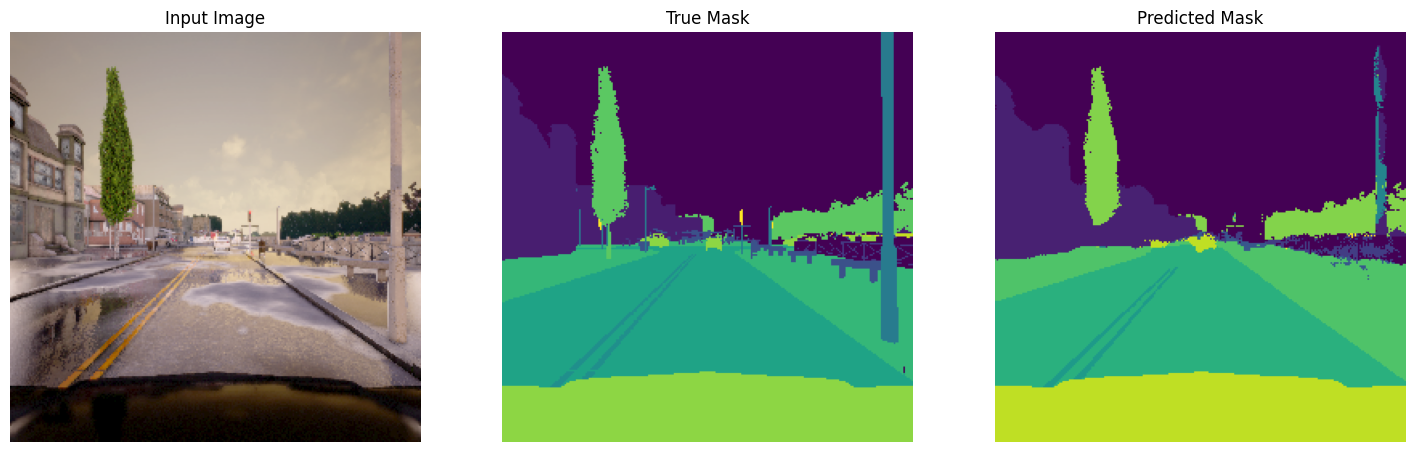

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


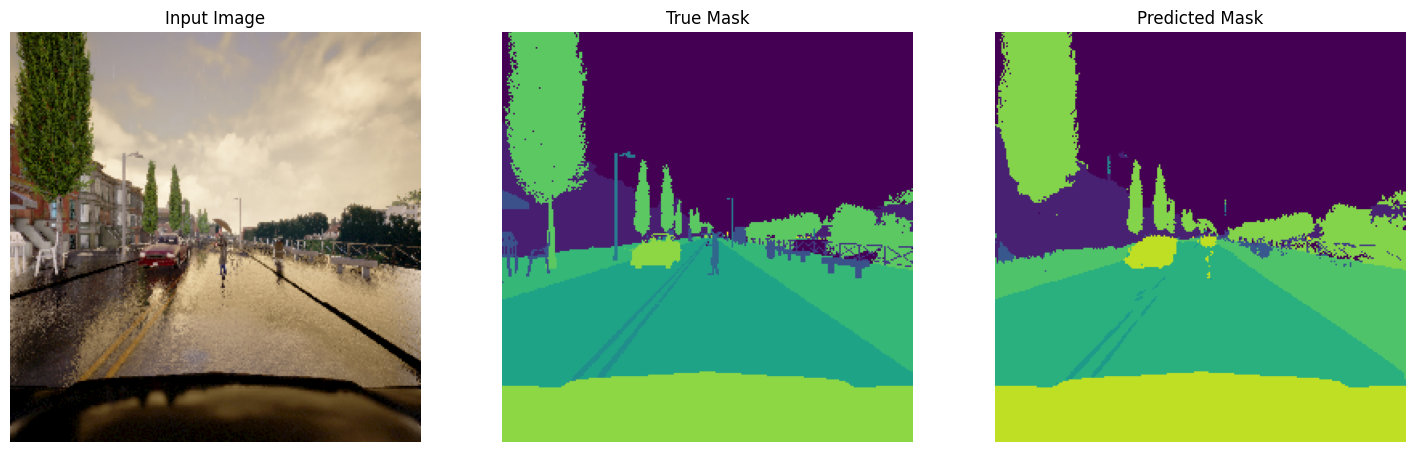

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


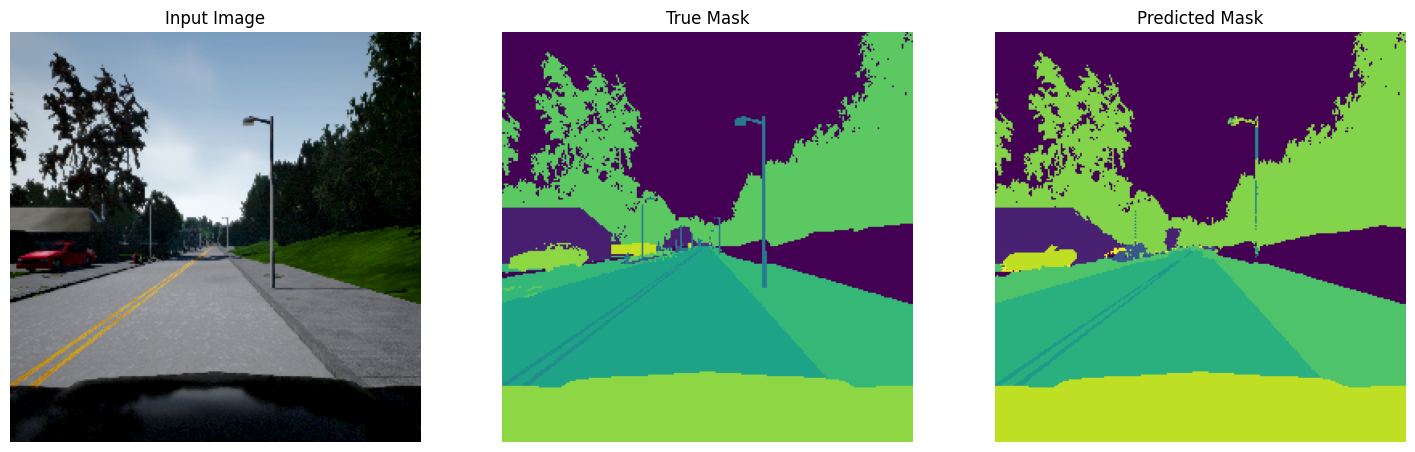

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


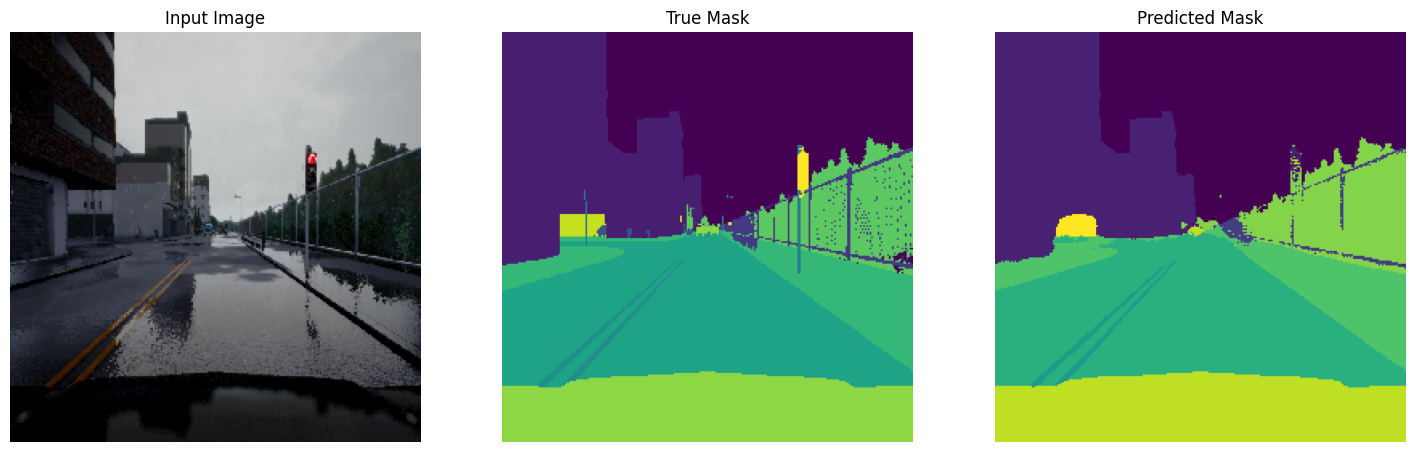

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


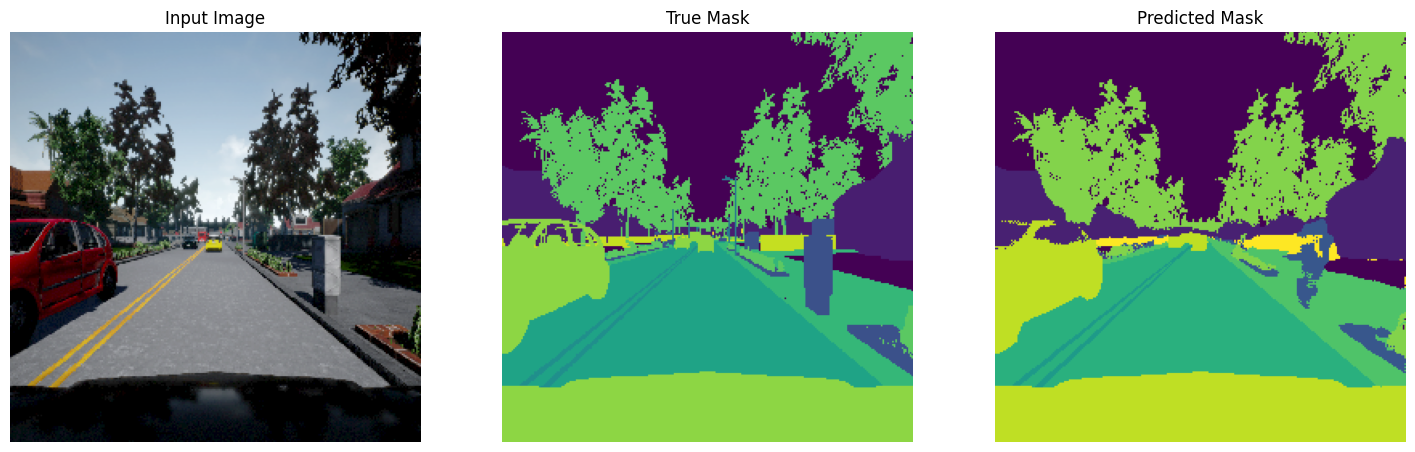

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


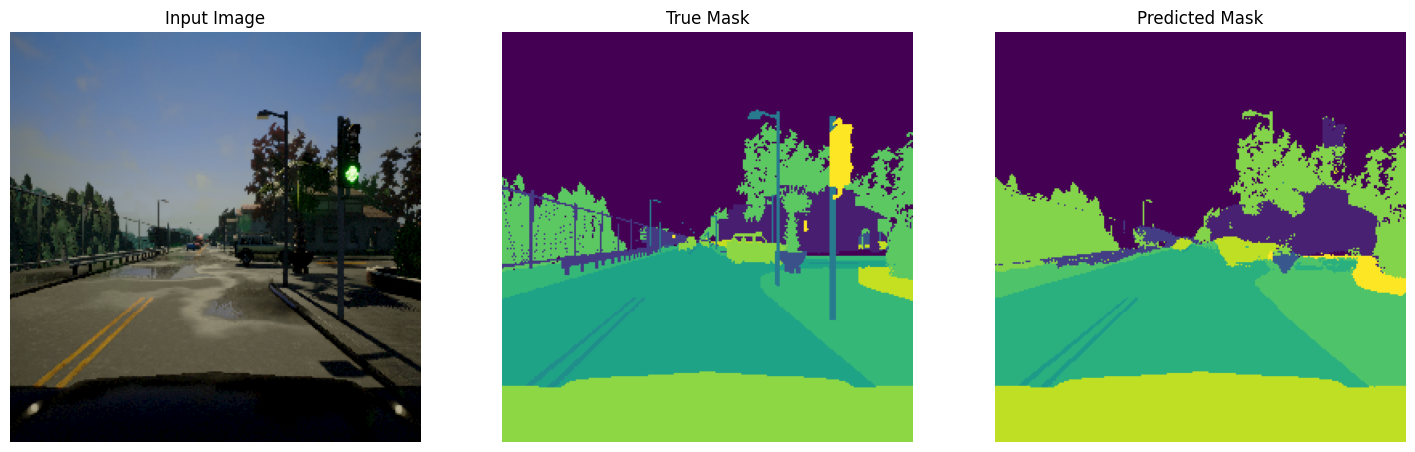

In [31]:
show_predictions(train_dataset, 6)

<a class="anchor" id="5-3" name="5-3"></a>
### **Predict and compare masks of images in the validation set**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


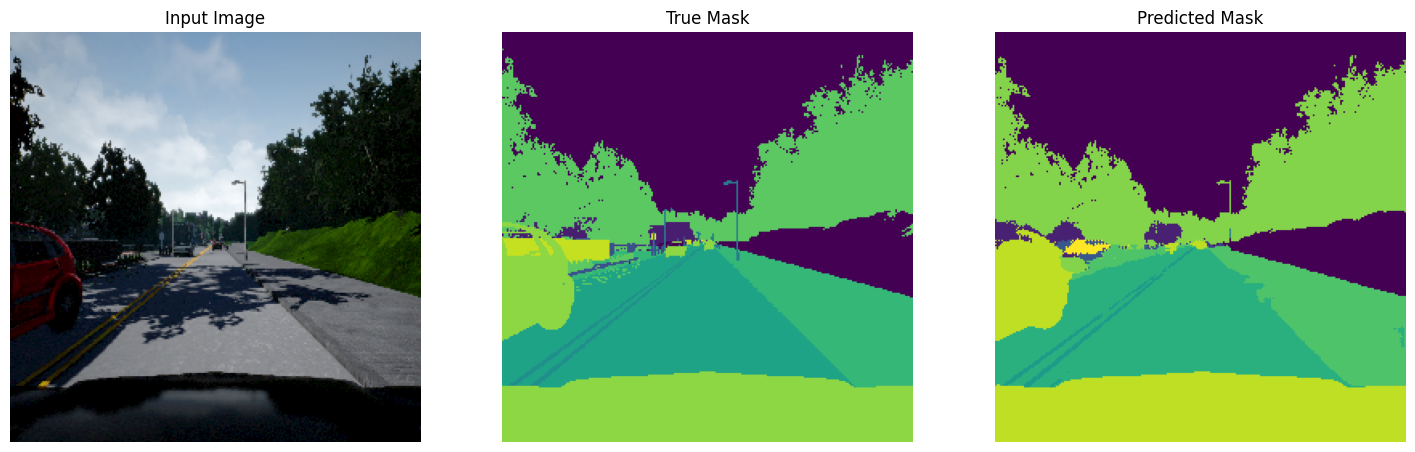

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


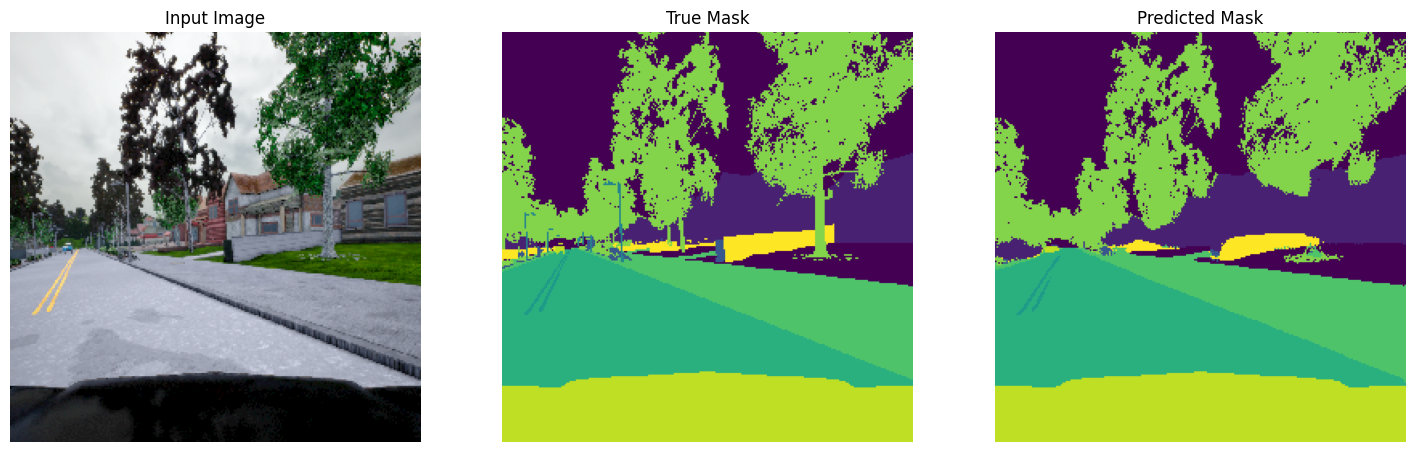

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


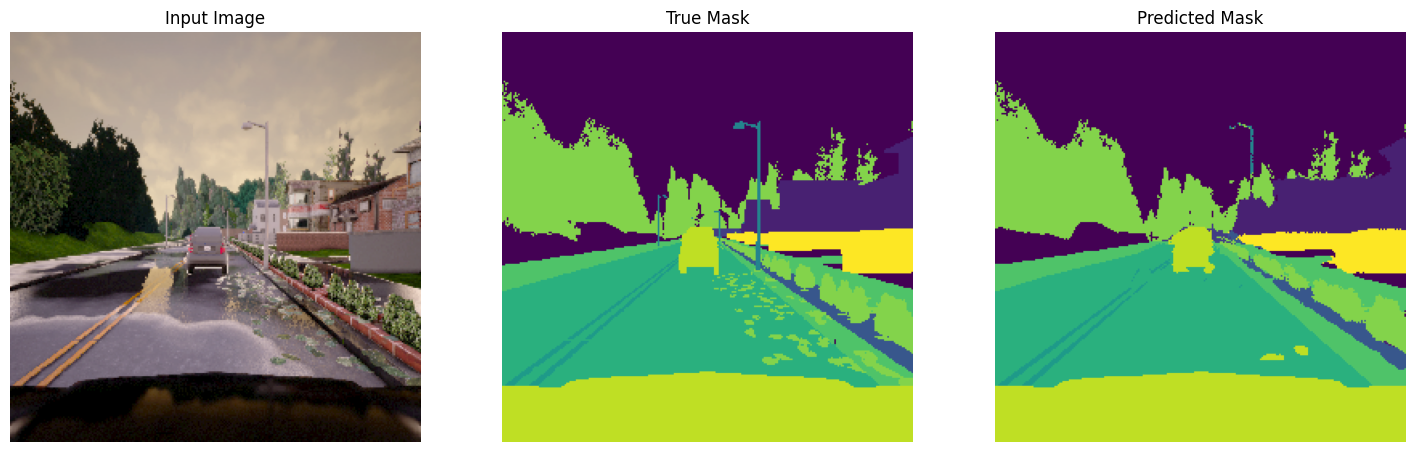

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


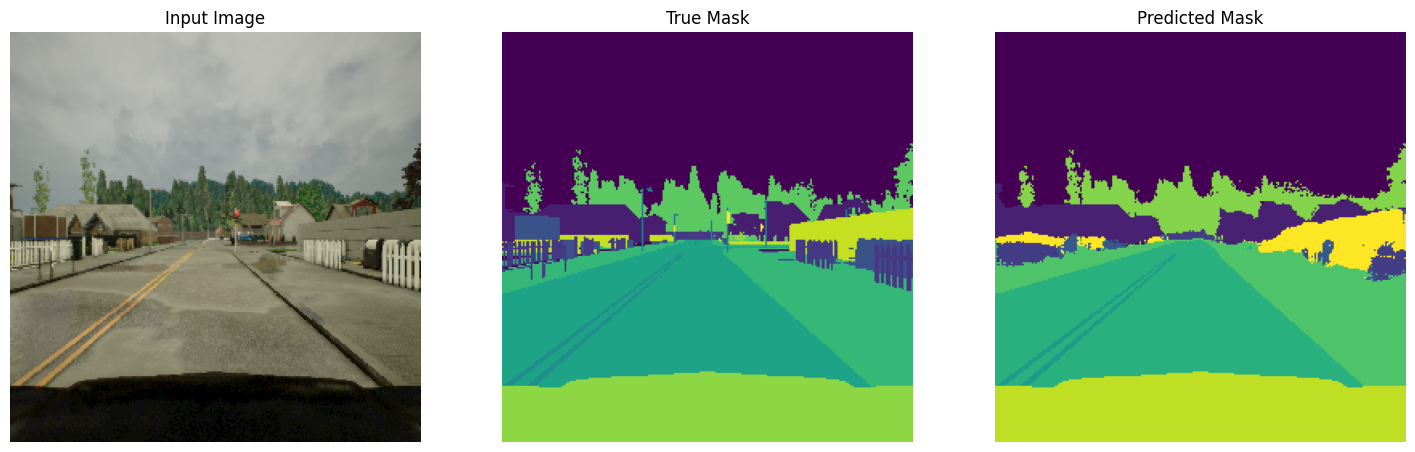

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


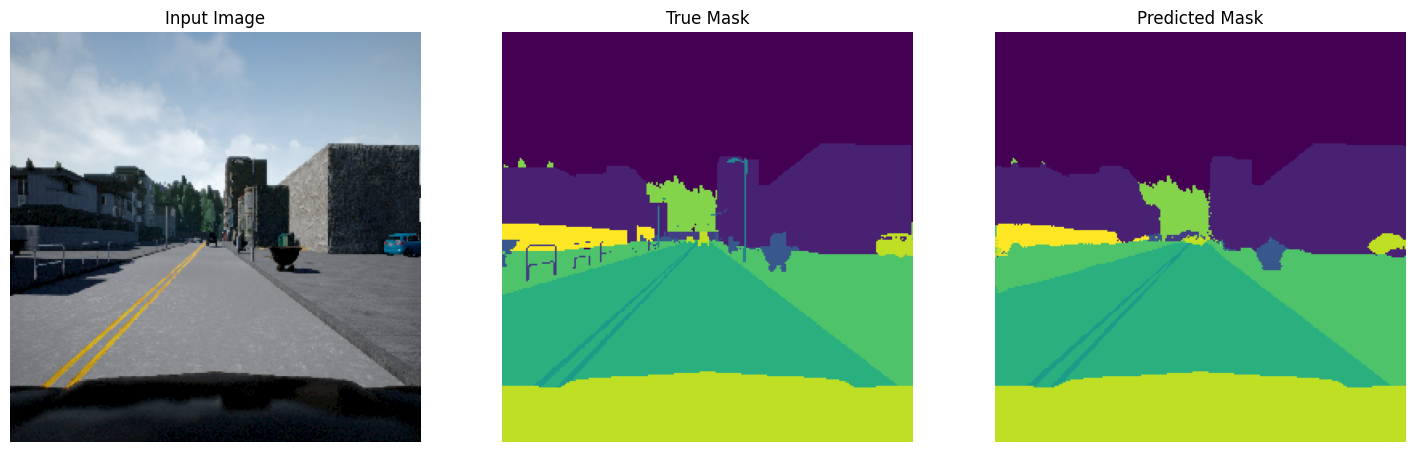

In [32]:
show_predictions(validation_dataset, 6)

<a class="anchor" id="5-4" name="5-4"></a>
### **Predict and compare masks of images in the test set**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


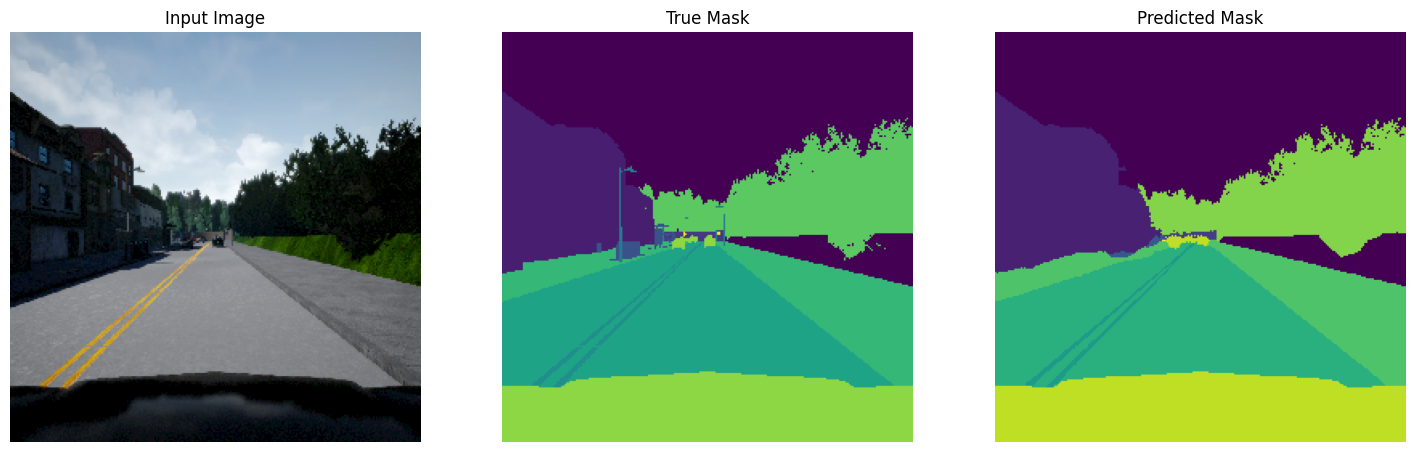

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


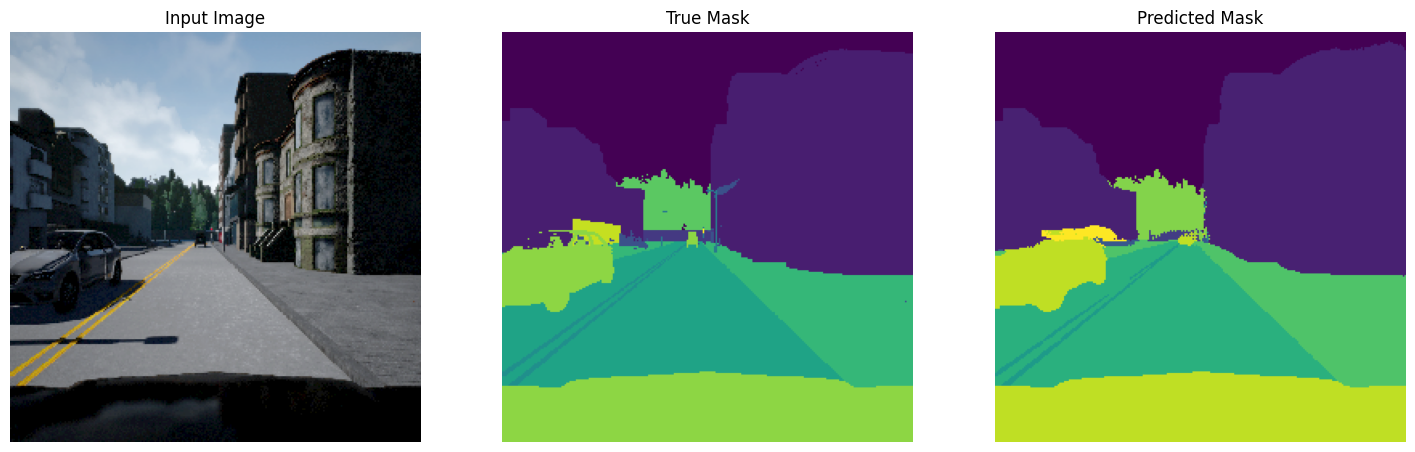

In [33]:
show_predictions(test_dataset, 6)